In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
Lamda_LPV = 0.47; % land-use factor or packing factor

PR = 0.85;  % Performance ratio expressing the difference between performace under standard test conditions and the actual output
            % of the system due to losses from sub-optimal angles, as well as cable and inverter losses 

% Lamda_PV: PV panel efficiency corrected for atmospheric variables 
  
Lamda_panel = 0.17; % Assumed Panel effeciency under standard conditions 
            
gamma  = -0.005; % Unit: °C -1 

T_stc  = 25; % Standard test conditions temperature

c1 = 4.3;    % Unit: °C 

c2 = 0.943;  % Unit:  1

c3 = 0.028;  % Unit: °C m2 W-1

c4 = -1.528; % Unit: °C s m-1

T  = c1 + c2.*ABT + c3.*I + c4.*Wind_speed;

Lamda_PV = Lamda_panel.*(1 + gamma.*(T-T_stc));

Power_pv = I.*Lamda_LPV.*Lamda_PV.*PR; 

end 

In [2]:
c1 = 4.3
c2 = 0.943
c3 = 0.028
c4 = -1.528

T_stc = 25
gamma = -0.005
lamda_panel = 0.17

Lamda_LPV = 0.47
PR = 0.85

In [3]:
from itertools import combinations
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

def evaluate(true, preds):
    mae = mean_absolute_error(true, preds)
    mse = mean_squared_error(true, preds)
    rmse = sqrt(mse)
    r2 = r2_score(true, preds)
    print(f"mae : {mae}")
    print(f"mse : {mse}")
    print(f"rmse : {rmse}")
    print(f"r2 : {r2}")

def calculate_pearsonr(data1, data2):
    return pearsonr(data1, data2)

def normalize_power_with_scaler(data):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    return normalized_data

In [4]:
test = pd.read_csv('test_data_nan_wind.csv', index_col='Date')
test.fillna(-1, inplace=True)

drop_columns = ['Day', 'Precipitation(mm)',
   'Humidity(%)', 'VaporPressure(hPa)', 'DewPointTemperature(C)',
   'Sunshine(hr)', 'Snowfall(cm)',
   'SnowfallLast3Hours(cm)', 'TotalCloudCoverage(1/10)',
   'MidLowCloudCoverage(1/10)', 'CloudForm', 'LowCloud(100m)',
   'Visibility(10m)', 'GroundState(code)', 'PhenomenonNumber', 'd2m',
   't2m', 'aerosol', 'Year']
test = test.drop(columns=drop_columns)

# 1 MJ/m2 = 277.78 W/m2 (for 1 hour duration)
test['solar_radiation(W/m2)'] = test['SolarRadiation(MJ/m2)'] * 277.78
test['power'] = test['power'] / 226000
#test['power'] = normalize_power_with_scaler(test[['power']])

In [5]:
test.head()

,Month,Hour,Temperature(C),SolarRadiation(MJ/m2),power,Wind_Speed,solar_radiation(W/m2)
Date,,,,,,,
2021-01-01 09:00:00,1,9,-1.5,0.30,0.212389,2.8,83.3340
2021-01-01 10:00:00,1,10,0.5,1.01,1.953982,2.1,280.5578
2021-01-01 11:00:00,1,11,2.0,0.96,4.715044,4.2,266.6688
2021-01-01 12:00:00,1,12,2.5,1.01,4.205310,2.7,280.5578
2021-01-01 13:00:00,1,13,2.9,1.01,11.171681,5.0,280.5578


In [6]:
test['T'] = c1 + c2*test['Temperature(C)'] + c3*test['solar_radiation(W/m2)'] + c4*test['Wind_Speed']
test['Lamda_PV'] = lamda_panel*(1 + gamma*(test['T'] - T_stc))
test['Power_pv'] = test['solar_radiation(W/m2)']*Lamda_LPV*test['Lamda_PV']*PR

In [7]:
true = test['power']
preds = test['Power_pv']

evaluate(true, preds)

mae : 5.237281946123815
mse : 52.5201275372767
rmse : 7.247077172024367
r2 : 0.7576905073001448


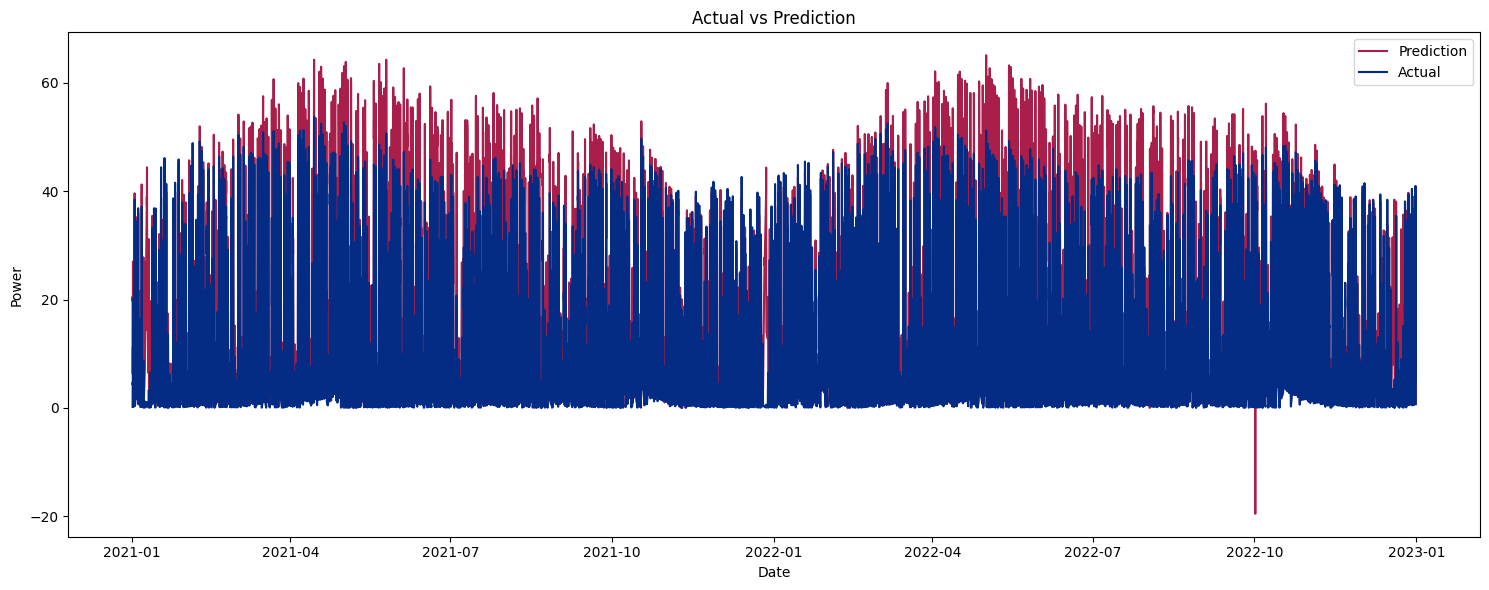

In [8]:
import matplotlib.pyplot as plt

test.index = pd.to_datetime(test.index)

# 그래프 그리기
plt.figure(figsize=(15, 6))

# 실제값과 예측값에 대한 꺾은선 그래프
plt.plot(test.index, preds, color='#AA1F4A', label='Prediction')
plt.plot(test.index, true, color='#042c84', label='Actual')


# 제목, 범례, x/y 레이블 추가
plt.title('Actual vs Prediction')
plt.xlabel('Date')
plt.ylabel('Power')
plt.legend()

# 그래프 표시
plt.tight_layout()
plt.show()

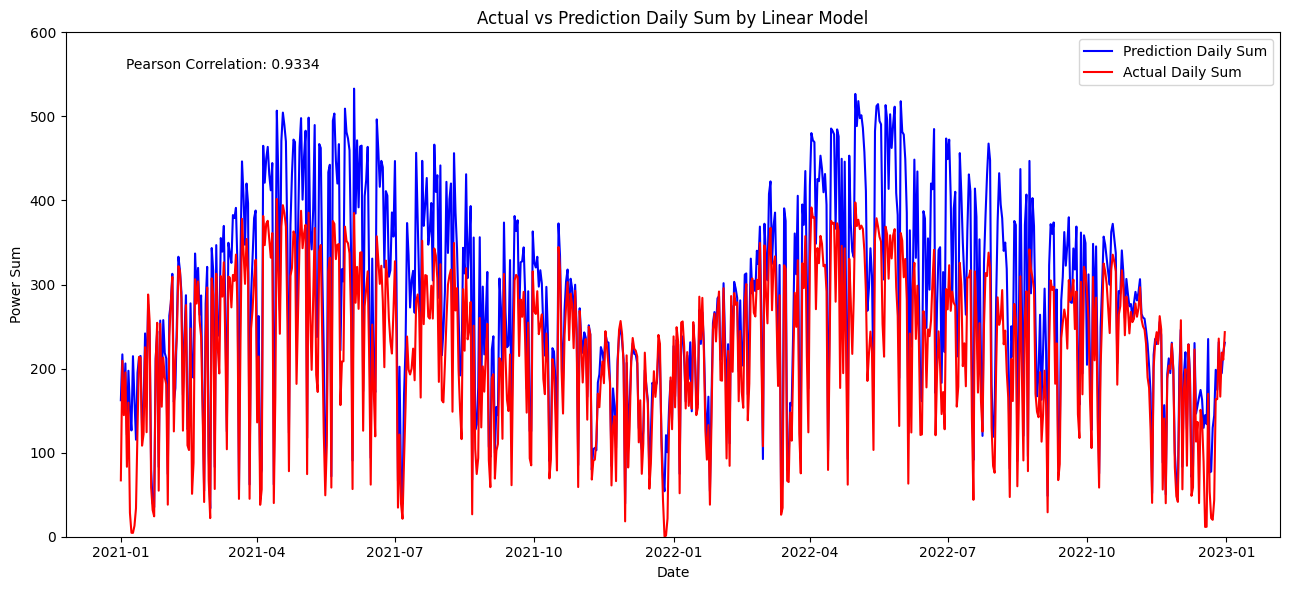

In [19]:
# 날짜별로 합계 계산
preds.index = test.index
true.index = test.index

daily_sum_true = true.resample('D').sum()
daily_sum_preds = preds.resample('D').sum()

# 그래프 그리기
plt.figure(figsize=(13, 6))
plt.ylim(0,600)
# 실제값과 예측값에 대한 꺾은선 그래프
plt.plot(daily_sum_true.index, daily_sum_preds, color='blue', label='Prediction Daily Sum')
plt.plot(daily_sum_true.index, daily_sum_true, color='red', label='Actual Daily Sum')
#c7cedd light
#042c84 blue
#AA1F4A red
# 제목, 범례, x/y 레이블 추가

corr_coefficient, _ = calculate_pearsonr(daily_sum_true, daily_sum_preds)
plt.text(0.05, 0.95, f'Pearson Correlation: {corr_coefficient:.4f}', transform=plt.gca().transAxes, verticalalignment='top')


plt.title('Actual vs Prediction Daily Sum by Linear Model')
plt.xlabel('Date')
plt.ylabel('Power Sum')
plt.legend()

# 그래프 표시
plt.tight_layout()
plt.show()


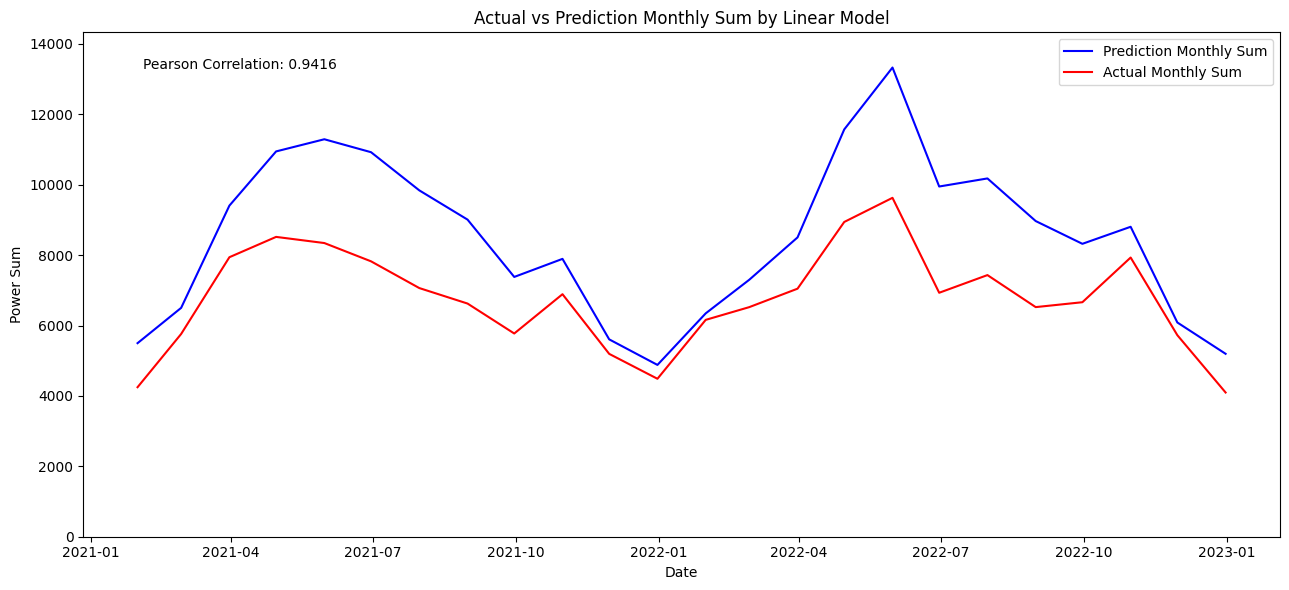

In [20]:
# 월별로 합계 계산
monthly_sum_true = true.resample('M').sum()
monthly_sum_preds = preds.resample('M').sum()

# 그래프 그리기
plt.figure(figsize=(13, 6))
plt.ylim(0, max(monthly_sum_true.max(), monthly_sum_preds.max()) + 1000)  # y축 범위 조정

# 실제값과 예측값에 대한 꺾은선 그래프
plt.plot(monthly_sum_true.index, monthly_sum_preds, color='blue', label='Prediction Monthly Sum')
plt.plot(monthly_sum_true.index, monthly_sum_true, color='red', label='Actual Monthly Sum')

# 상관 계수 계산 및 텍스트 표시
corr_coefficient_monthly, _ = calculate_pearsonr(monthly_sum_true, monthly_sum_preds)
plt.text(0.05, 0.95, f'Pearson Correlation: {corr_coefficient_monthly:.4f}', transform=plt.gca().transAxes, verticalalignment='top')

# 제목, 범례, x/y 레이블 추가
plt.title('Actual vs Prediction Monthly Sum by Linear Model')
plt.xlabel('Date')
plt.ylabel('Power Sum')
plt.legend()

# 그래프 표시
plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import mean_squared_error

# RMSE 계산 함수
def calculate_rmse(true_values, predicted_values):
    return mean_squared_error(true_values, predicted_values, squared=False)

# 일별 RMSE 계산
daily_rmse = calculate_rmse(daily_sum_true, daily_sum_preds)

# 월별 RMSE 계산
monthly_rmse = calculate_rmse(monthly_sum_true, monthly_sum_preds)

print("일별 RMSE:", daily_rmse)
print("월별 RMSE:", monthly_rmse)

일별 RMSE: 72.8054833289528
월별 RMSE: 2006.6177981964672


In [16]:
# 일별 데이터 정규화 (최솟값 빼기 없이)
daily_true_normalized = daily_sum_true / daily_sum_true.max()
daily_preds_normalized = daily_sum_preds / daily_sum_true.max()

# 월별 데이터 정규화 (최솟값 빼기 없이)
monthly_true_normalized = monthly_sum_true / monthly_sum_true.max()
monthly_preds_normalized = monthly_sum_preds / monthly_sum_true.max()

# 정규화된 데이터로 RMSE 계산
daily_rmse_normalized = calculate_rmse(daily_true_normalized, daily_preds_normalized)
monthly_rmse_normalized = calculate_rmse(monthly_true_normalized, monthly_preds_normalized)

daily_rmse_normalized, monthly_rmse_normalized


(0.18119911407503583, 0.2084131250305162)

In [18]:
def calculate_mape(true_values, predicted_values):
    return 100 * (np.abs((true_values - predicted_values) / true_values)).mean()

# 일별 MAPE 계산
daily_mape = calculate_mape(daily_sum_true, daily_sum_preds)

# 월별 MAPE 계산
monthly_mape = calculate_mape(monthly_sum_true, monthly_sum_preds)

daily_mape, monthly_mape


(72.59133330096172, 24.547853556582023)